# Feature Selection

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from config import *

In [2]:
features_raw = pd.read_parquet(FEATURES_DIR / "features.pq")
features_raw.shape

(192, 485)

In [3]:
# Drop participants where all features are null
features = features_raw[~(features_raw.isna().sum(axis=1) == features_raw.shape[1]-2)]
features.shape

(171, 485)

In [4]:
y = pd.DataFrame(features["y"], columns=["y"])
X = features.drop(["participant_id", "y"], axis=1)
X.shape

(171, 483)

## Criteria 1: Minimum accepted variance of features

$$
v_f < mav = 0.01
$$

In [5]:
from sklearn.feature_selection import VarianceThreshold

In [6]:
selector = VarianceThreshold(threshold=0.01)
min_variance_features = selector.fit_transform(X)

# Get the selected feature names
min_variance_features_names = X.columns[selector.get_support()]

# Create data_frame with min variance features
X1 = X[min_variance_features_names]

print(f"Kept {X1.shape[1]} features out of {X.shape[1]}")

Kept 448 features out of 483


In [7]:
X1.shape

(171, 448)

## Criteria 2: Maximum accepted correlation of features

$$
r_{f_{x}f_{y}} < mac = 0.85
$$

In [ ]:
# Calculate the correlation matrix
corr_matrix = X1.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Compute variance
variance = X1.var()

to_drop = set()
for column in upper.columns:
    corr_features = upper.index[upper[column] > 0.85].tolist()
    for corr_feature in corr_features:
        if variance[column] < variance[corr_feature]:
            to_drop.add(column)
        else:
            to_drop.add(corr_feature)    

X2 = X1.drop(columns=to_drop)

print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")

Removed 217 highly correlated features: {'SHAPES_distance_to_fixpoint_median', 'SHAPES_duration_std_sacc', 'FIXATIONS_peak_velocity_mean_sacc', 'SHAPES_x_acceleration_max', 'SMOOTH_PURSUITS_y_acceleration_max', 'SMOOTH_PURSUITS_fixation_distance_mean', 'REACTION_y_acceleration_median', 'FIXATIONS_fixations_per_second_median', 'EVIL_BASTARD_distance_to_fixpoint_max', 'KING_DEVICK_duration_median_fix', 'KING_DEVICK_x_acceleration_max', 'KING_DEVICK_y_acceleration_min', 'SHAPES_x_fixation_dist_mean', 'FIXATIONS_y_acceleration_median', 'SHAPES_total_acceleration_magnitude_median', 'SMOOTH_PURSUITS_fixation_distance_median', 'SHAPES_distance_to_fixpoint_y_mean', 'EVIL_BASTARD_total_acceleration_magnitude_min', 'EVIL_BASTARD_avg_pupil_size_max_fix', 'EVIL_BASTARD_x_acceleration_max', 'ANTI_SACCADE_avg_pupil_size_mean_fix', 'KING_DEVICK_total_acceleration_magnitude_min', 'EVIL_BASTARD_distance_to_fixpoint_y_median', 'FIXATIONS_amplitude_median_sacc', 'REACTION_total_acceleration_magnitude_mea

In [9]:
X2.shape

(171, 231)

## 2-sample t-test

In [12]:
from scipy import stats

In [54]:
control = X2.merge(y, left_index=True, right_index=True).query('y==0')
patient = X2.merge(y, left_index=True, right_index=True).query('y==1')
sig_features = []

for feature in X2.columns:
    if feature in ["participant_id", 'y']:
        continue
    t_stat, p_value = stats.ttest_ind(control[control[feature].notna()][feature], patient[patient[feature].notna()][feature])
    alpha = 0.05
    if p_value < alpha:
        sig_features.append([feature,p_value])

len(sig_features)

24

In [14]:
sig_features_df = pd.DataFrame(sig_features, columns=["Feature", "P-value"])
top_20_features_significance = list(sig_features_df.sort_values("P-value").head(20)["Feature"])

In [15]:
top_20_features_significance

['REACTION_reaction_time_avg',
 'KING_DEVICK_avg_time_elapsed_pr_trial',
 'REACTION_reaction_time_std',
 'EVIL_BASTARD_fixations_per_second_max',
 'EVIL_BASTARD_distance_to_fixpoint_x_max',
 'FITTS_LAW_duration_std_fix',
 'FITTS_LAW_duration_max_sacc',
 'SMOOTH_PURSUITS_distance_to_fixpoint_x_std',
 'FITTS_LAW_duration_mean_sacc',
 'FITTS_LAW_duration_mean_fix',
 'EVIL_BASTARD_distance_to_fixpoint_y_max',
 'ANTI_SACCADE_peak_velocity_median_sacc',
 'SHAPES_avg_pupil_size_std_fix',
 'SMOOTH_PURSUITS_total_acceleration_magnitude_median',
 'EVIL_BASTARD_duration_max_sacc',
 'SMOOTH_PURSUITS_distance_to_fixpoint_y_max',
 'SMOOTH_PURSUITS_peak_velocity_mean_sacc',
 'KING_DEVICK_avg_pupil_size_std_fix',
 'SMOOTH_PURSUITS_amplitude_max_sacc',
 'SMOOTH_PURSUITS_fixations_per_second_max']

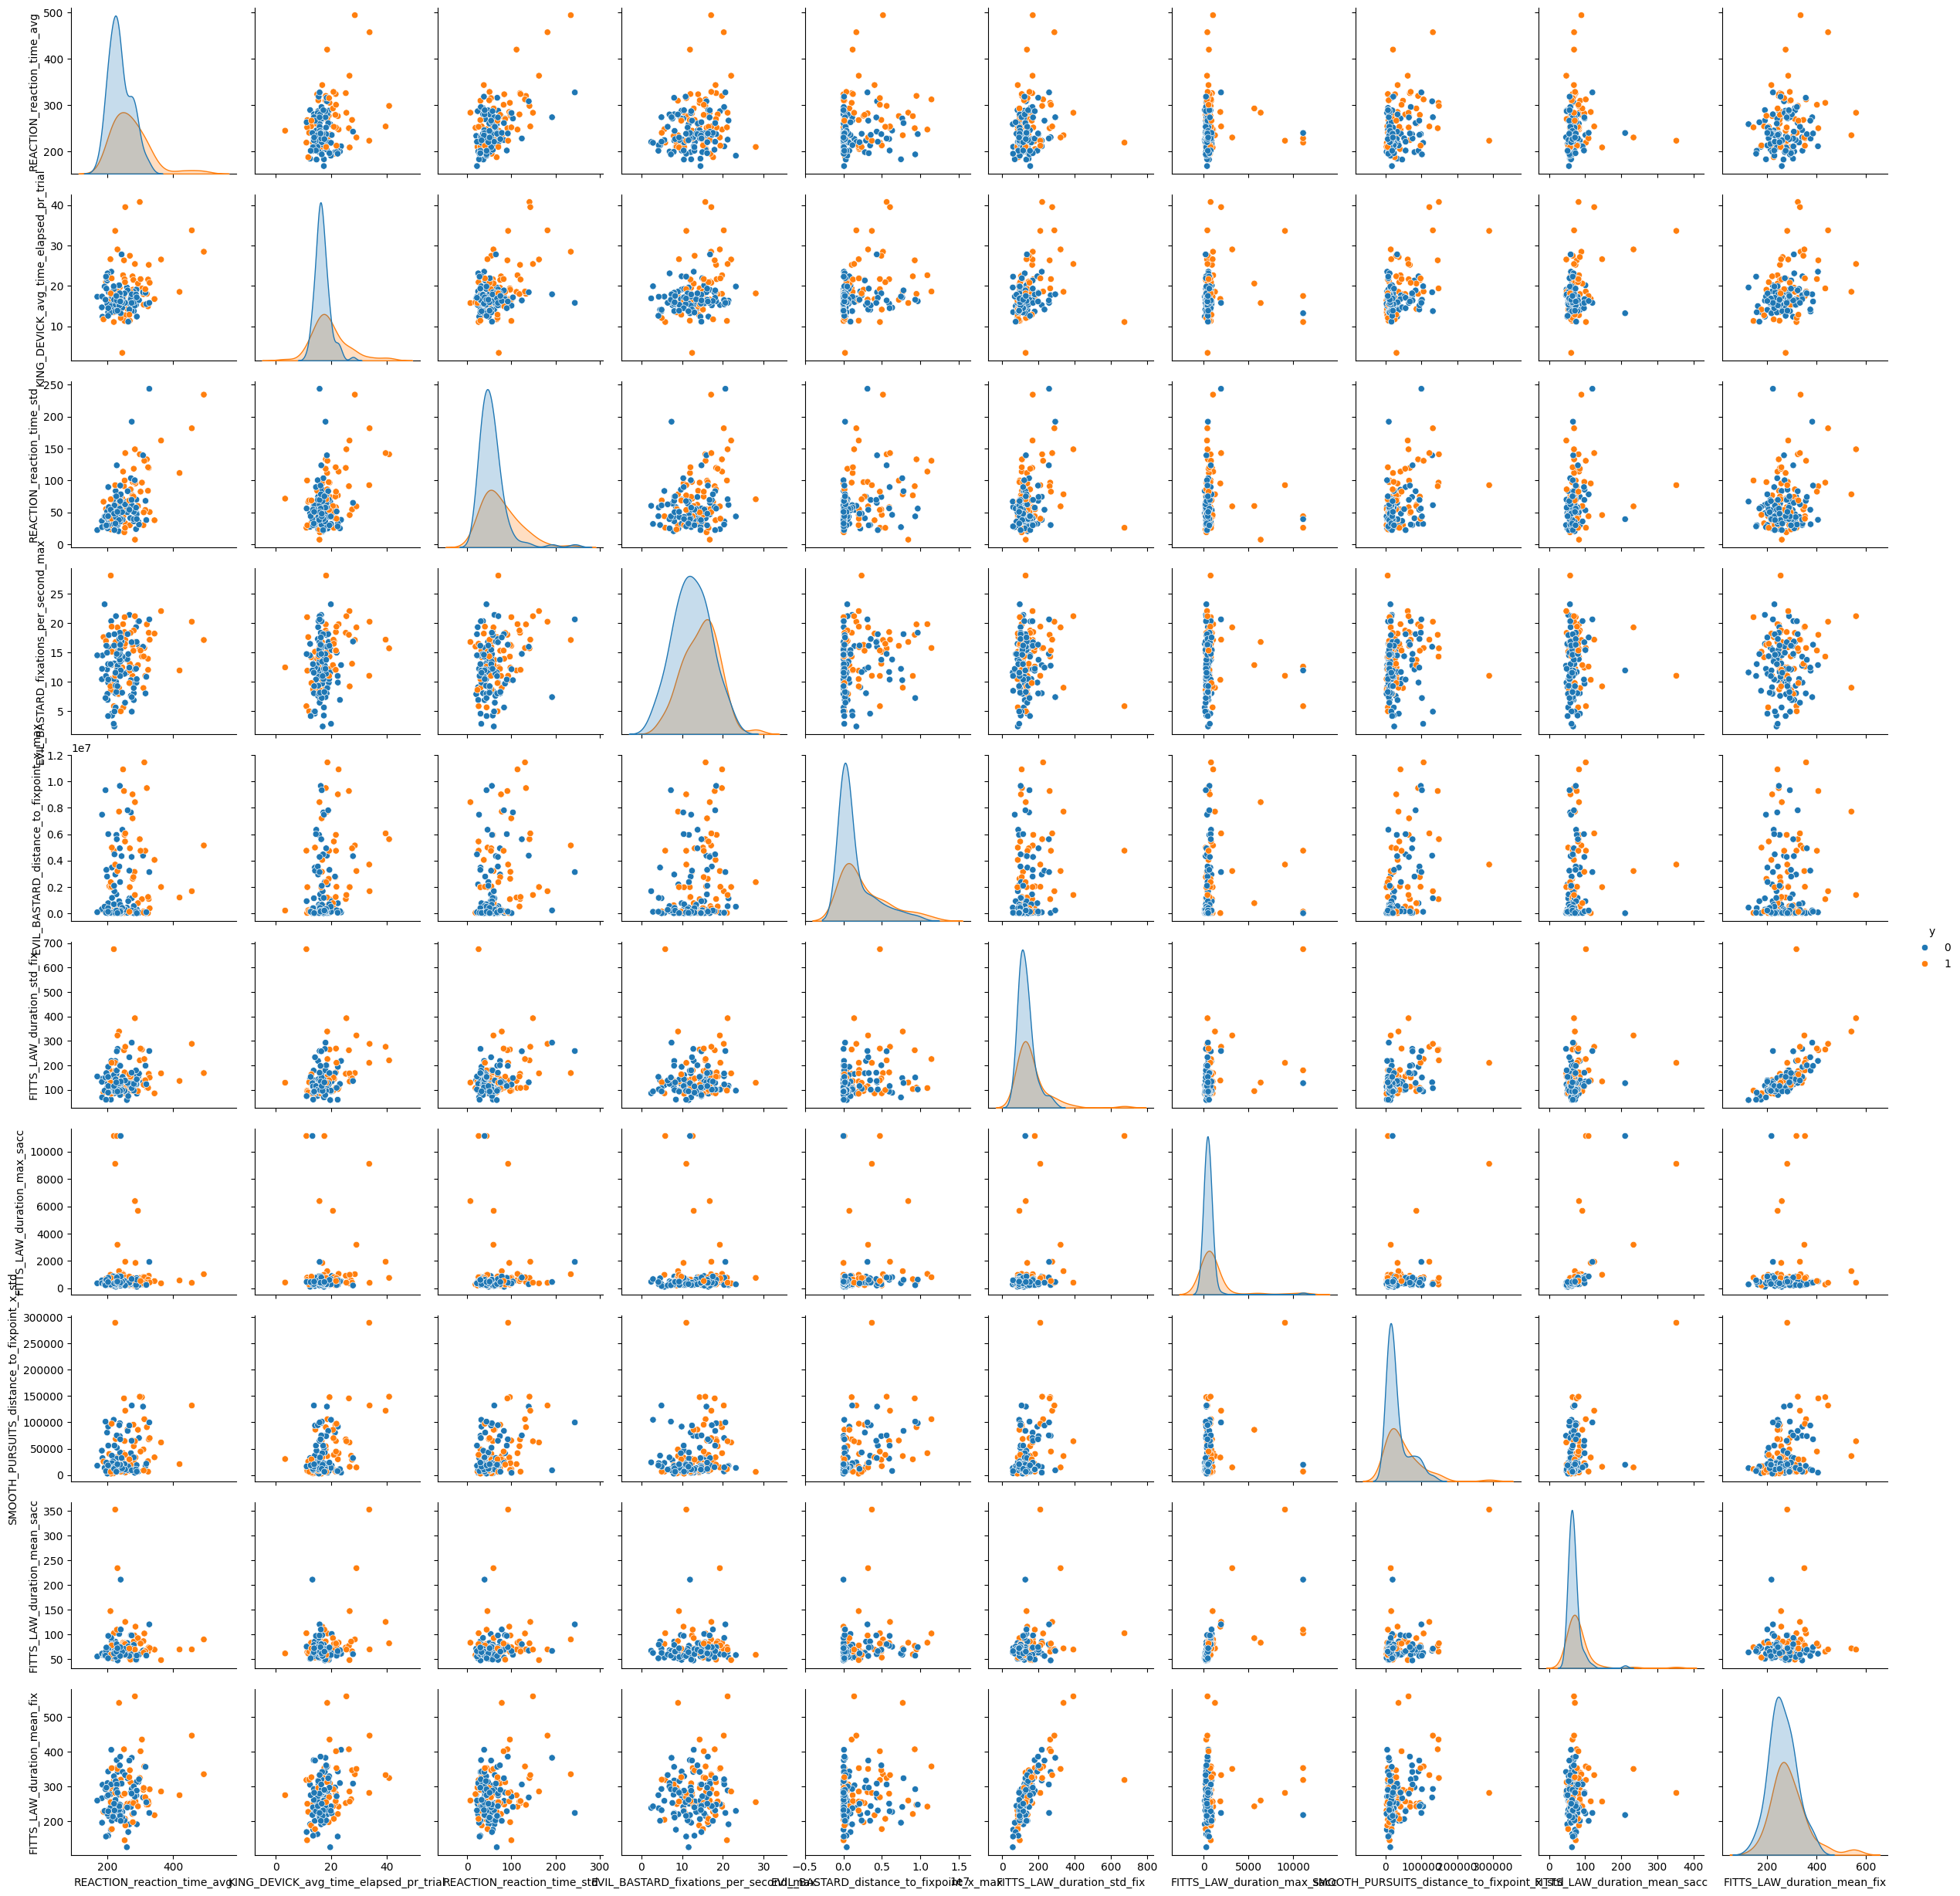

In [307]:
top_10_features_significance = list(sig_features_df.sort_values("P-value").head(10)["Feature"])
sns.pairplot(features[top_10_features_significance + ['y']], hue='y')

## Random forest

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from kneed import KneeLocator

In [58]:
def get_feature_importance_exp(X, y):
    experiments = ["ANTI_SACCADE", "FITTS_LAW", "FIXATIONS", "KING_DEVICK", "EVIL_BASTARD", "REACTION", "SHAPES", "SMOOTH_PURSUITS"]

    # Reshape y
    y = y.values.ravel()

    # Get feature importances for each experiment
    feature_importances_exp = pd.DataFrame(np.zeros(X.shape[1]), columns=["Importance"], index=X.columns)
    best_rf_params_exp = {}
    
    for exp in experiments:
        exp_features = [f for f in X.columns if exp in f]
        X_exp = X[exp_features]
        
        # Hyperparameters for GridSearch
        parameters = {
            'max_depth': [None, 3, 5, 7, 9, 11],
            'n_estimators': [20, 30, 40, 50, 70, 100],
            'max_features': ['sqrt', 'log2', None]
        }

        # Find best clf
        grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=42), parameters, cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_exp, y)
        
        best_rf = grid_search.best_estimator_
        importances = best_rf.feature_importances_
        best_rf_params_exp[exp] = grid_search.best_params_
        
        # update importances and counts
        feature_importances_exp.loc[exp_features, "Importance"] += importances
    
    return feature_importances_exp, best_rf_params_exp

feature_importances_exp, best_rf_params_exp = get_feature_importance_exp(X2,y)

In [57]:
def get_feature_importance(X, y):
    # Reshape y
    y = y.values.ravel()
    
    # Get feature importances for all experiments
    feature_importances = pd.DataFrame(np.zeros(X.shape[1]), columns=["Importance"], index=X.columns)
    best_rf_params = {}

    # Hyperparameters for GridSearch
    parameters = {
        'max_depth': [None, 3, 5, 7, 9, 11],
        'n_estimators': [20, 30, 40, 50, 70, 100],
        'max_features': ['sqrt', 'log2', None]
    }

    # Find best clf
    grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=42), parameters, cv=5, verbose=0, n_jobs=-1)
    grid_search.fit(X, y)
    
    best_rf = grid_search.best_estimator_
    importances = best_rf.feature_importances_
    best_rf_params = grid_search.best_params_
    
    # update importances and counts
    feature_importances["Importance"] = importances
    
    return feature_importances, best_rf_params

feature_importances, best_rf_params = get_feature_importance(X2,y)

In [59]:
best_rf_params_exp

{'ANTI_SACCADE': {'max_depth': 3, 'max_features': None, 'n_estimators': 70},
 'FITTS_LAW': {'max_depth': 5, 'max_features': None, 'n_estimators': 70},
 'FIXATIONS': {'max_depth': None, 'max_features': 'log2', 'n_estimators': 30},
 'KING_DEVICK': {'max_depth': 3, 'max_features': None, 'n_estimators': 50},
 'EVIL_BASTARD': {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20},
 'REACTION': {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50},
 'SHAPES': {'max_depth': 3, 'max_features': None, 'n_estimators': 100},
 'SMOOTH_PURSUITS': {'max_depth': 3,
  'max_features': 'sqrt',
  'n_estimators': 20}}

In [60]:
best_rf_params

{'max_depth': 5, 'max_features': None, 'n_estimators': 100}

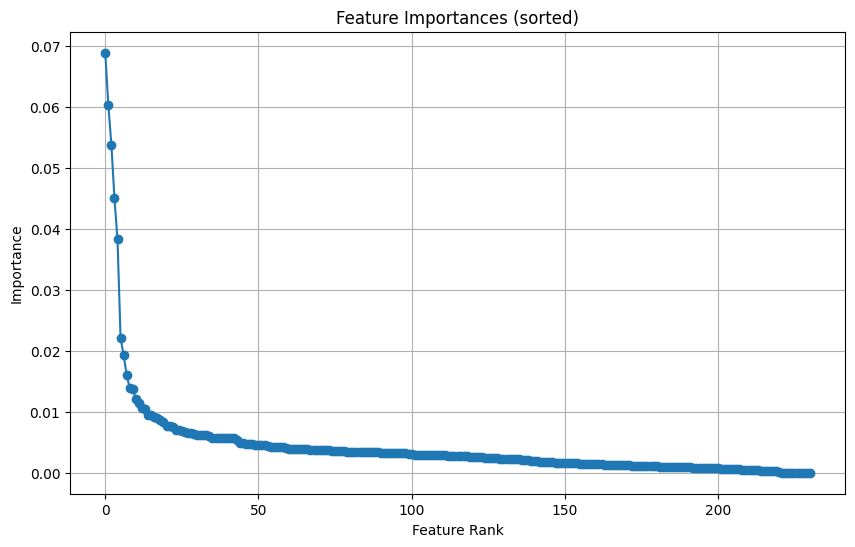

In [61]:
# Sort importances descending
sorted_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.plot(np.arange(len(sorted_importances)), sorted_importances["Importance"].values, marker='o')
plt.title("Feature Importances (sorted)")
plt.xlabel("Feature Rank")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

In [64]:
def get_important_features_exp(feature_importances):
    experiments = ["ANTI_SACCADE", "FITTS_LAW", "FIXATIONS", "KING_DEVICK", "EVIL_BASTARD", "REACTION", "SHAPES", "SMOOTH_PURSUITS"]
    
    important_features = {}
    for exp in experiments:
        # exp_features = [f for f in feature_importances.index if exp in f]
        feature_importances_exp = feature_importances.filter(like=exp,axis=0)
        
        # Get the sorted importance values
        sorted_importances_exp = feature_importances_exp.sort_values(by="Importance", ascending=False)
        importance_values_exp = sorted_importances_exp["Importance"].values

        # Find knee
        knee = KneeLocator(
            np.arange(len(importance_values_exp)), 
            importance_values_exp, 
            curve='convex', 
            direction='decreasing'
        )

        knee_point = knee.knee
        print(f"{exp}: Knee detected at feature rank {knee_point}")

        # Select features above knee
        important_features_exp = sorted_importances_exp.iloc[:knee_point+1]
        print(f"Automatically selected {important_features_exp.shape[0]} features")
        
        important_features[exp]=important_features_exp
        
    return important_features
    
important_features_exp = get_important_features_exp(feature_importances_exp)

ANTI_SACCADE: Knee detected at feature rank 2
Automatically selected 3 features
FITTS_LAW: Knee detected at feature rank 1
Automatically selected 2 features
FIXATIONS: Knee detected at feature rank 6
Automatically selected 7 features
KING_DEVICK: Knee detected at feature rank 5
Automatically selected 6 features
EVIL_BASTARD: Knee detected at feature rank 4
Automatically selected 5 features
REACTION: Knee detected at feature rank 3
Automatically selected 4 features
SHAPES: Knee detected at feature rank 4
Automatically selected 5 features
SMOOTH_PURSUITS: Knee detected at feature rank 5
Automatically selected 6 features


In [ ]:
def get_important_features(feature_importances):    
    important_features = []
    
    # Get the sorted importance values
    sorted_importances = feature_importances.sort_values(by="Importance", ascending=False)
    importance_values = sorted_importances["Importance"].values

    # Find knee
    knee = KneeLocator(
        np.arange(len(importance_values)), 
        importance_values, 
        curve='convex', 
        direction='decreasing'
    )

    knee_point = knee.knee
    print(f"Knee detected at feature rank {knee_point}")

    # Select features above knee
    important_features = sorted_importances.iloc[:knee_point+1]
    print(f"Automatically selected {important_features.shape[0]} features")
        
    return important_features
    
important_features = get_important_features(feature_importances)

Knee detected at feature rank 20
Automatically selected 21 features


In [66]:
important_features

,Importance
KING_DEVICK_avg_time_elapsed_pr_trial,0.068844
FITTS_LAW_duration_max_sacc,0.060290
REACTION_reaction_time_avg,0.053784
ANTI_SACCADE_reaction_time_avg,0.044963
REACTION_reaction_time_std,0.038231
REACTION_duration_max_sacc,0.022096
SHAPES_peak_velocity_max_sacc,0.019268
ANTI_SACCADE_peak_velocity_median_sacc,0.016010
ANTI_SACCADE_amplitude_median_sacc,0.013819
KING_DEVICK_peak_velocity_mean_sacc,0.013745


In [81]:
important_features_exp_df = pd.concat(important_features_exp.values(), keys=important_features_exp.keys()).reset_index(level=0, drop=True)

## Feature selection

In [101]:
feature_list = list(set(important_features.index).union(set(important_features_exp_df.index)).union(set(sig_features_df.Feature)))

In [102]:
len(feature_list)

59

In [106]:
features_raw[["participant_id", "y"]+feature_list]

,participant_id,y,FITTS_LAW_fixations_per_second_std,ANTI_SACCADE_reaction_time_avg,SHAPES_fixation_distance_min,FITTS_LAW_duration_max_sacc,REACTION_duration_max_sacc,EVIL_BASTARD_distance_to_fixpoint_y_max,FITTS_LAW_amplitude_median_sacc,SMOOTH_PURSUITS_distance_to_fixpoint_y_max,...,ANTI_SACCADE_Var_total,KING_DEVICK_duration_mean_fix,SMOOTH_PURSUITS_total_acceleration_magnitude_median,KING_DEVICK_wrong_direction_saccade_pct_std,KING_DEVICK_Var_total,SMOOTH_PURSUITS_amplitude_max_sacc,SMOOTH_PURSUITS_Var_total,SHAPES_amplitude_std_sacc,FITTS_LAW_duration_std_fix,SHAPES_duration_max_fix
0,105,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,138,1,0.326391,401.333333,NaN,11143.0,5271.0,927488.05,12.740,NaN,...,2474.567956,163.958333,NaN,2.884291,3326.187458,NaN,NaN,NaN,675.021677,NaN
2,103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106,1,0.295355,284.625000,13.201515,350.0,236.0,217622.25,11.050,2151208.89,...,1342.526365,196.554377,64.167857,4.302666,2641.343824,26.05,2386.051431,3.293065,113.960652,2711.0
4,151,1,0.426021,327.187500,10.231813,456.0,499.0,1129331.29,10.000,2509372.81,...,2197.271580,238.009926,82.654253,1.845930,4740.704517,25.93,3740.437941,4.443741,109.046784,2656.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,379,0,0.620537,266.937500,7.963040,453.0,382.0,411393.96,10.550,1917948.01,...,10123.002756,215.596215,103.213125,3.539040,5659.009074,15.77,15999.034263,3.823358,153.142122,5756.0
188,402,0,0.272123,317.375000,6.181424,408.0,414.0,198737.64,10.720,1901641.00,...,4666.587648,244.291545,78.044729,0.211746,2342.962715,19.89,7686.173602,3.645595,198.000615,2482.0
189,395,1,0.403161,430.687500,8.508819,534.0,470.0,984460.84,6.055,2606610.25,...,1320.267880,254.222222,425.463294,5.248577,1410.327114,25.01,1752.592618,2.950196,268.889394,3930.0
190,401,0,0.468538,275.312500,11.766053,459.0,588.0,332698.24,10.815,1621802.25,...,4398.317947,234.976623,30.869698,5.086400,2968.257512,16.86,1620.657861,3.782528,130.521730,8280.0
